Installation is simple:

```
Pkg.add("Stan")
```

You need to install CmdStan first though. Get it from [here](http://mc-stan.org/users/interfaces/cmdstan). You also need to set the `CMDSTAN_HOME` environment variable, which should point to the folder in which you unpacked `CmdStan`.

This notebook assumes that you have created a `CmdStanDir` variable (mostly likely by setting it in your `~/.juliarc.jl` file) and that it points to the location in which you unpacked CmdStan.

In [1]:
using Stan

# Use the describe function from Mamba.
#
using Mamba

Check that environment variable is set.

In [2]:
ENV["CMDSTAN_HOME"]

"/opt/cmdstan-2.17.1/"

## Load Data

In [3]:
using RData

In [4]:
pwd()

"/home/colliera/proj/Z-317-talk-first-steps-stan/julia"

In [5]:
slots = load("/home/colliera/proj/Z-317-talk-first-steps-stan/maud-sessions.rda", convert=true)
slots = slots["sessions_stats"];

In [6]:
size(slots, 1)

100

In [7]:
names(slots)

7-element Array{Symbol,1}:
 :session 
 :spins   
 :hits    
 :wager   
 :payout  
 :hit_rate
 :rtp     

In [8]:
slots[1:6,:]

,session,spins,hits,wager,payout,hit_rate,rtp
1,1,7,2,10,3.0,0.285714,0.3
2,2,19,7,30,29.0,0.368421,0.966667
3,3,19,3,22,3.0,0.157895,0.136364
4,4,26,7,30,13.0,0.269231,0.433333
5,5,23,8,31,35.0,0.347826,1.12903
6,6,20,8,26,12.0,0.4,0.461538


Define a model.

In [9]:
const binomial_model = "
data {
  int<lower=0> N;
  int hits[N];
  int spins[N];
}
parameters {
  real<lower=0,upper=1> theta;
}
model {
  hits ~ binomial(spins, theta);       // Likelihood
  theta ~ beta(2, 2);                  // Prior
}
";

Create a `Stanmodel` object. This specifies the basic attributes for the model.

In [44]:
stanmodel = Stanmodel(model=binomial_model, nchains=4);

That will actually take the model string and write it to a temporary external file with `.stan` extension. The `name` argument can be used to specify the name of this file.

Take a look at the model object.

In [11]:
stanmodel |> display

  name =                    "noname"
  nchains =                 4
  num_samples =             1000
  num_warmup =                   1000
  thin =                    1
  useMamba =                true
  mambaThinning =           1
  monitors =                String[]
  model_file =              "noname.stan"
  data_file =               ""
  output =                  Output()
    file =                    ""
    diagnostics_file =        ""
    refresh =                 100
  method =                  Sample()
    num_samples =             1000
    num_warmup =              1000
    save_warmup =             false
    thin =                    1
    algorithm =               HMC()
      engine =                  NUTS()
        max_depth =               10
      metric =                  

Interrogate attributes of the model.

In [12]:
stanmodel.method

Stan.diag_e
      stepsize =                1.0
      stepsize_jitter =         1.0
    adapt =                   Adapt()
      gamma =                   0.05
      delta =                   0.8
      kappa =                   0.75
      t0 =                      10.0
      init_buffer =             75
      term_buffer =             50
      window =                  25


Update characteristics of model. The `Stanmodel` object can be tailored either via the constructor or after the fact.

In [13]:
stanmodel.method.adapt.delta = 0.85

0.85

  method =                  Sample()
    num_samples =             1000
    num_warmup =              1000
    save_warmup =             false
    thin =                    1
    algorithm =               HMC()
      engine =                  NUTS()
        max_depth =               10
      metric =                  Stan.diag_e
      stepsize =                1.0
      stepsize_jitter =         1.0
    adapt =                   Adapt()
      gamma =                   0.05
      delta =                   0.8
      kappa =                   0.75
      t0 =                      10.0
      init_buffer =             75
      term_buffer =             50
      window =                  25


Set up the observed input data.

In [14]:
const binomial_data = Dict("N"     => size(slots, 1),
                           "hits"  => slots[:hits],
                           "spins" => slots[:spins])

Dict{String,Any} with 3 entries:
  "hits"  => Int32[2, 7, 3, 7, 8, 8, 5, 4, 4, 8  …  8, 5, 2, 2, 10, 8, 3, 5, 4,…
  "N"     => 100
  "spins" => Int32[7, 19, 19, 26, 23, 20, 22, 22, 18, 26  …  19, 16, 14, 18, 21…

Build the code and run the simulation. Uses `make` to recompile code, but only if necessary. Multiple chains are run in parallel (if possible).

In [40]:
rc, simulated = stan(stanmodel, [binomial_data], diagnostics=false);


make: '/home/colliera/proj/Z-317-talk-first-steps-stan/julia/tmp/noname' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

Calling /opt/cmdstan-2.17.1/bin/stansummary to infer across chains.

Inference for Stan model: noname_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (0.025, 0.024, 0.026, 0.026) seconds, 0.10 seconds total
Sampling took (0.047, 0.044, 0.059, 0.058) seconds, 0.21 seconds total

                 Mean     MCSE  StdDev     5%    50%    95%  N_Eff  N_Eff/s    R_hat
lp__            -1229  1.9e-02    0.74  -1230  -1229  -1228   1471     7095  1.0e+00
accept_stat__    0.94  1.6e-03   0.087   0.75   0.98    1.0   3024    14583  1.0e+00
stepsize__       0.90  6.7e-02   0.094   0.78   0.96    1.0    2.0      9.7  7.5e+13
treedepth__       1.5  1.1e-01    0.61    1.0    1.0    3.0     28      137  1.0e+00
n_leapfrog__      2.9  2.7e-01     1

Check on whether the simulation completed without error.

In [30]:
rc

0

In [16]:
stanmodel.command

4-element Array{Base.AbstractCmd,1}:
 `./noname sample num_samples=1000 num_warmup=1000 save_warmup=0 thin=1 adapt engaged=1 gamma=0.05 delta=0.85 kappa=0.75 t0=10.0 init_buffer=75 term_buffer=50 window=25 algorithm=hmc engine=nuts max_depth=10 metric=diag_e stepsize=1.0 stepsize_jitter=1.0 random seed=-1 id=1 data file=noname_1.data.R output file=noname_samples_1.csv refresh=100`
 `./noname sample num_samples=1000 num_warmup=1000 save_warmup=0 thin=1 adapt engaged=1 gamma=0.05 delta=0.85 kappa=0.75 t0=10.0 init_buffer=75 term_buffer=50 window=25 algorithm=hmc engine=nuts max_depth=10 metric=diag_e stepsize=1.0 stepsize_jitter=1.0 random seed=-1 id=2 data file=noname_2.data.R output file=noname_samples_2.csv refresh=100`
 `./noname sample num_samples=1000 num_warmup=1000 save_warmup=0 thin=1 adapt engaged=1 gamma=0.05 delta=0.85 kappa=0.75 t0=10.0 init_buffer=75 term_buffer=50 window=25 algorithm=hmc engine=nuts max_depth=10 metric=diag_e stepsize=1.0 stepsize_jitter=1.0 random seed=-1

Subset sampler output.

In [55]:
monitor = ["theta", "lp__"]
#
simulated = simulated[:, monitor, :]

Object of type "Mamba.Chains"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

[0.325964 -1229.18; 0.302436 -1228.99; … ; 0.311263 -1228.47; 0.307145 -1228.62]

[0.344737 -1232.85; 0.348173 -1233.84; … ; 0.320135 -1228.66; 0.336046 -1230.77]

[0.309568 -1228.51; 0.321672 -1228.77; … ; 0.313737 -1228.45; 0.313226 -1228.45]

[0.327053 -1229.31; 0.324682 -1229.04; … ; 0.320833 -1228.71; 0.323448 -1228.92]

## Diagnostics

`Mamba` provides a range of [convergence diagnostics](http://mambajl.readthedocs.io/en/latest/tutorial.html#convergence-diagnostics).

In [46]:
gelmandiag(simulated, mpsrf=true, transform=true) |> showall

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Gelman, Rubin, and Brooks Diagnostic:
               PSRF 97.5%
        theta 1.002 1.007
         lp__ 1.001 1.003
accept_stat__ 1.038 1.079
 Multivariate 1.051   NaN



The diagnostic of Geweke tests for non-convergence of posterior mean estimates per chain. Convergence is rejected for significant p-values.

In [47]:
println("Geweke Convergence Diagnostic (one block for each chain)")
gewekediag(simulated) |> display

              Z-score p-value
        theta   0.739  0.4601
         lp__  -0.775  0.4386
accept_stat__  -0.851  0.3949

              Z-score p-value
        theta  -1.375  0.1692
         lp__  -1.669  0.0951
accept_stat__  -1.162  0.2451

              Z-score p-value
        theta   2.374  0.0176
         lp__   0.991  0.3219
accept_stat__   0.814  0.4156

              Z-score p-value
        theta   0.105  0.9164
         lp__  -1.136  0.2561
accept_stat__  -1.742  0.0815



Geweke Convergence Diagnostic (one block for each chain)


In [48]:
heideldiag(simulated) |> showall

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Heidelberger and Welch Diagnostic:
Target Halfwidth Ratio = 0.1
Alpha = 0.05

              Burn-in Stationarity p-value      Mean        Halfwidth  Test
        theta       0            1  0.1027     0.31336863 0.0011391847    1
         lp__       0            1  0.2571 -1228.94543000 0.0674596134    1
accept_stat__       0            1  0.1070     0.93266081 0.0059018801    1

              Burn-in Stationarity p-value      Mean        Halfwidth  Test
        theta     200            1  0.3327      0.3149359 0.0010397819    1
         lp__       0            1  0.2335  -1228.9567800 0.0690961358    1
accept_stat__       0            1  0.4375      0.9267510 0.0060027491    1

              Burn-in Stationarity p-value      Mean        Halfwidth  Test
        theta       0            1  0.1202     0.31318548 0.0010621960    1
         lp__       0            1  0.4918 -1228.92698000 0.0695202507    1

## Interrogating the Chains

Check for success and examine results. The `simulated` object is of type `Mamba.Chains`.

In [ ]:
describe(simulated)

In [36]:
describe(simulated[:, ["theta"], :], q=[0.025, 0.5, 0.975])

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
         Mean         SD        Naive SE        MCSE      ESS
theta 0.31289054 0.010642713 0.00016827606 0.00029036710 1000

Quantiles:
         2.5%      50.0%     97.5%  
theta 0.29309677 0.312797 0.33427225



Highest Posterior Density Intervals.

In [49]:
hpd(simulated)

                95% Lower    95% Upper 
        theta     0.293906     0.335203
         lp__ -1230.430000 -1228.450000
accept_stat__     0.752862     1.000000



Cross-Correlations.

In [50]:
cor(simulated)

                  theta        lp__    accept_stat__
        theta  1.000000000 -0.07989330   0.000444265
         lp__ -0.079893297  1.00000000   0.475896832
accept_stat__  0.000444265  0.47589683   1.000000000



Lag-Autocorrelations.

In [51]:
autocor(simulated)

                  Lag 1         Lag 5        Lag 10        Lag 50   
        theta    0.44533071   0.044738655   0.03188223  -0.034848518
         lp__    0.39427652  -0.030617627   0.05000131  -0.044470949
accept_stat__   -0.02173016   0.044203351   0.05085721  -0.032659798

                  Lag 1         Lag 5        Lag 10        Lag 50   
        theta   0.462219918 -0.0060135804  0.012351701   0.017487387
         lp__   0.428862244  0.0277297300  0.033080617  -0.041879567
accept_stat__  -0.012954078  0.0020326984 -0.004022964  -0.007864278

                  Lag 1         Lag 5        Lag 10        Lag 50   
        theta  0.4045521070   0.035312867 0.0038263004  0.0139231737
         lp__  0.4590124841  -0.046110632 0.0592127835 -0.0186993889
accept_stat__ -0.0044323484   0.028400936 0.0393834973 -0.0013058813

                  Lag 1         Lag 5        Lag 10        Lag 50   
        theta   0.543478236   0.065501012  0.021637341   -0.07218575
         lp__   0.626252339   0

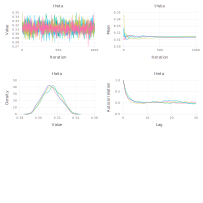

In [75]:
dark_panel = Theme(
    panel_fill="black",
    default_color="orange"
)
Gadfly.push_theme(dark_panel)
p = plot(simulated[:, ["theta"], :], [:trace, :mean, :density, :autocor], legend=false);
draw(p)
# draw(p, ncol=2, filename="summaryplot", fmt=:svg)
draw(p, ncol=2, filename="summaryplot.pdf", fmt=:pdf, width=8inch, height=4inch)

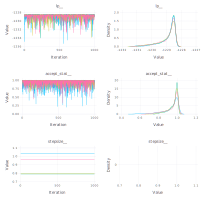

Press ENTER to draw next plot
stdin> 


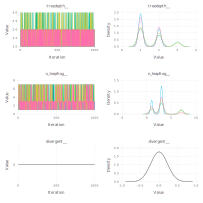

Press ENTER to draw next plot
stdin> 


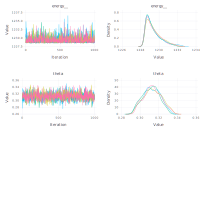

In [37]:
## Default summary plot (trace and density plots)
p = plot(simulated)

## Write plot to file
# draw(p, filename="summaryplot.svg")
draw(p)